In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
def read_data(csv):
    df = pd.read_csv(csv)
    
    print("Columns found in CSV:", df.columns.tolist())
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').asfreq('H')  # Set frequency to hourly
    
    return df

In [5]:
def train_test_split(df, test_size=0.1):
    """
    Split the data into training and testing sets
    """
    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]
    return train, test

In [17]:
def plot_train_test(train, test, predictions):
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(train.index, train['load'], label='Training Data', color='blue', linewidth=1)
    
    # Plot testing data
    plt.plot(test.index, test['load'], label='Testing Data', color='orange', linewidth=1)
    
    # Plot predictions
    plt.plot(test.index, predictions, label='Predictions', color='red', linestyle='--', linewidth=2)
    
    plt.title('Train-Test Split with Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
def plot_comprehensive_analysis(df):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Load and Temperature Plot
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax1.plot(df.index, df['load'], label='Energy Load', color='blue', linewidth=1)
    ax1.set_title('Energy Load Over Time')
    ax1.set_ylabel('Load (MW)')
    ax1.grid(True)
    
    ax1t = ax1.twinx()
    ax1t.plot(df.index, df['temp'], color='red', label='Temperature', alpha=0.6)
    ax1t.set_ylabel('Temperature (°F)')
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1t.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 2. Daily Load Pattern
    ax2 = plt.subplot2grid((3, 2), (1, 0))
    daily_avg = df.groupby(df.index.hour)['load'].mean()
    ax2.plot(daily_avg.index, daily_avg.values, color='blue', linewidth=1)
    ax2.set_title('Average Daily Load Pattern')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Average Load (MW)')
    ax2.grid(True)
    
    # 3. Load Distribution
    ax3 = plt.subplot2grid((3, 2), (1, 1))
    ax3.hist(df['load'], bins=50, color='blue', alpha=0.6)
    ax3.set_title('Load Distribution')
    ax3.set_xlabel('Load (MW)')
    ax3.set_ylabel('Frequency')
    
    # 4. Load vs Temperature Scatter
    ax4 = plt.subplot2grid((3, 2), (2, 0))
    ax4.scatter(df['temp'], df['load'], alpha=0.1, color='purple')
    ax4.set_title('Load vs Temperature')
    ax4.set_xlabel('Temperature (°F)')
    ax4.set_ylabel('Load (MW)')
    ax4.grid(True)
    
    # 5. Temperature Distribution
    ax5 = plt.subplot2grid((3, 2), (2, 1))
    ax5.hist(df['temp'], bins=50, color='red', alpha=0.6)
    ax5.set_title('Temperature Distribution')
    ax5.set_xlabel('Temperature (°F)')
    ax5.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [11]:
def check_stationarity(timeseries):
    # ADF Test for getting stationarity and if not differencing to be performed
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test:')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    # Stationarity plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
    
    # Original Load
    ax1.plot(timeseries)
    ax1.set_title('Original Load')
    ax1.grid(True)
    
    # Rolling Statistics
    rolling_mean = timeseries.rolling(window=24).mean()  # Changed to 24 for hourly data
    rolling_std = timeseries.rolling(window=24).std()
    ax2.plot(timeseries, label='Original', alpha=0.5)
    ax2.plot(rolling_mean, label='24-hour Rolling Mean', color='red')
    ax2.plot(rolling_std, label='24-hour Rolling Std', color='green')
    ax2.set_title('Rolling Statistics')
    ax2.grid(True)
    ax2.legend()
    
    # First Difference
    ax3.plot(timeseries.diff().dropna())
    ax3.set_title('First Difference')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return result[1] < 0.05


In [13]:
def plot_forecast_results(original_data, predictions, forecast):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    plt.plot(original_data.index, original_data, label='Historical Data', color='blue', linewidth=1)
    
    # Plot fitted values
    plt.plot(predictions.index, predictions, label='Fitted Values', color='red', alpha=0.7, linewidth=1)
    
    # Plot forecast
    forecast_index = pd.date_range(start=original_data.index[-1], periods=len(forecast)+1, closed='right')
    plt.plot(forecast_index, forecast, label='Forecast', color='green', linewidth=2)
    
    plt.title('Energy Load Forecast using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.legend()
    plt.grid(True)
    plt.show()

Reading data from CSV...
Columns found in CSV: ['timestamp', 'load', 'temp']

Successfully loaded data!
Date range: 2012-01-01 00:00:00 to 2014-12-31 23:00:00

Generating analysis plots...


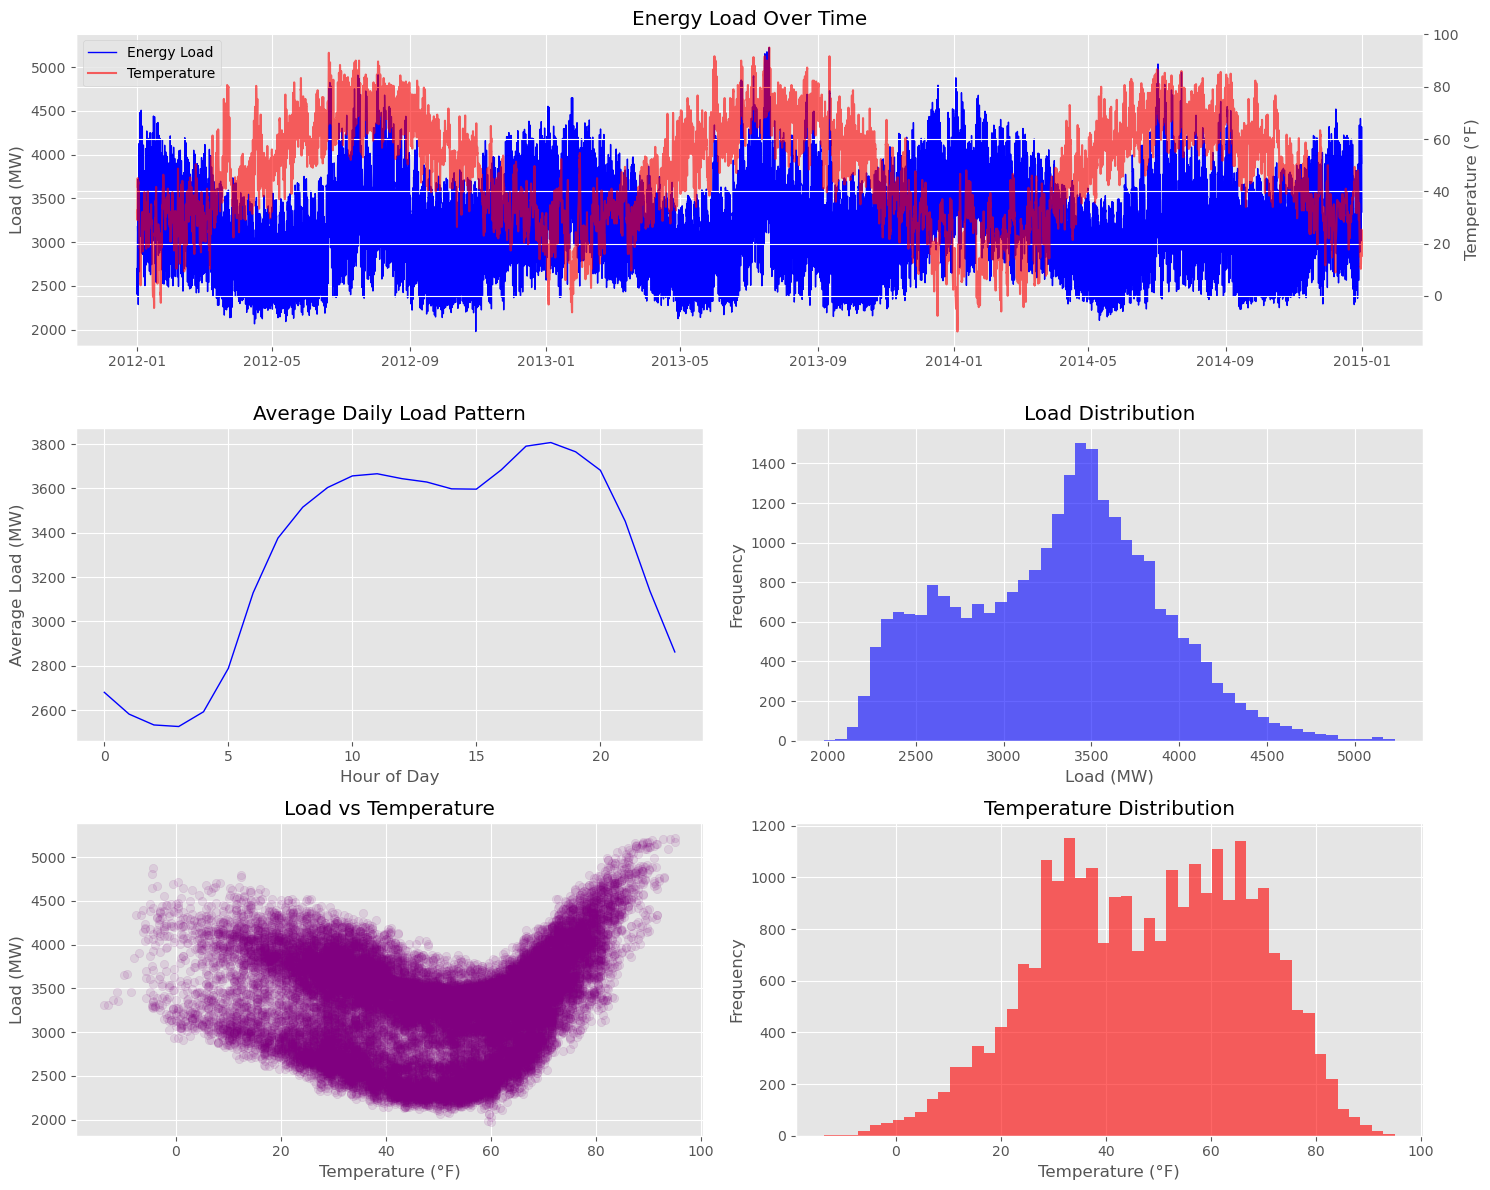


Checking stationarity...
Augmented Dickey-Fuller Test:
ADF Statistic: -10.404080285485204
p-value: 1.876514522339819e-18
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


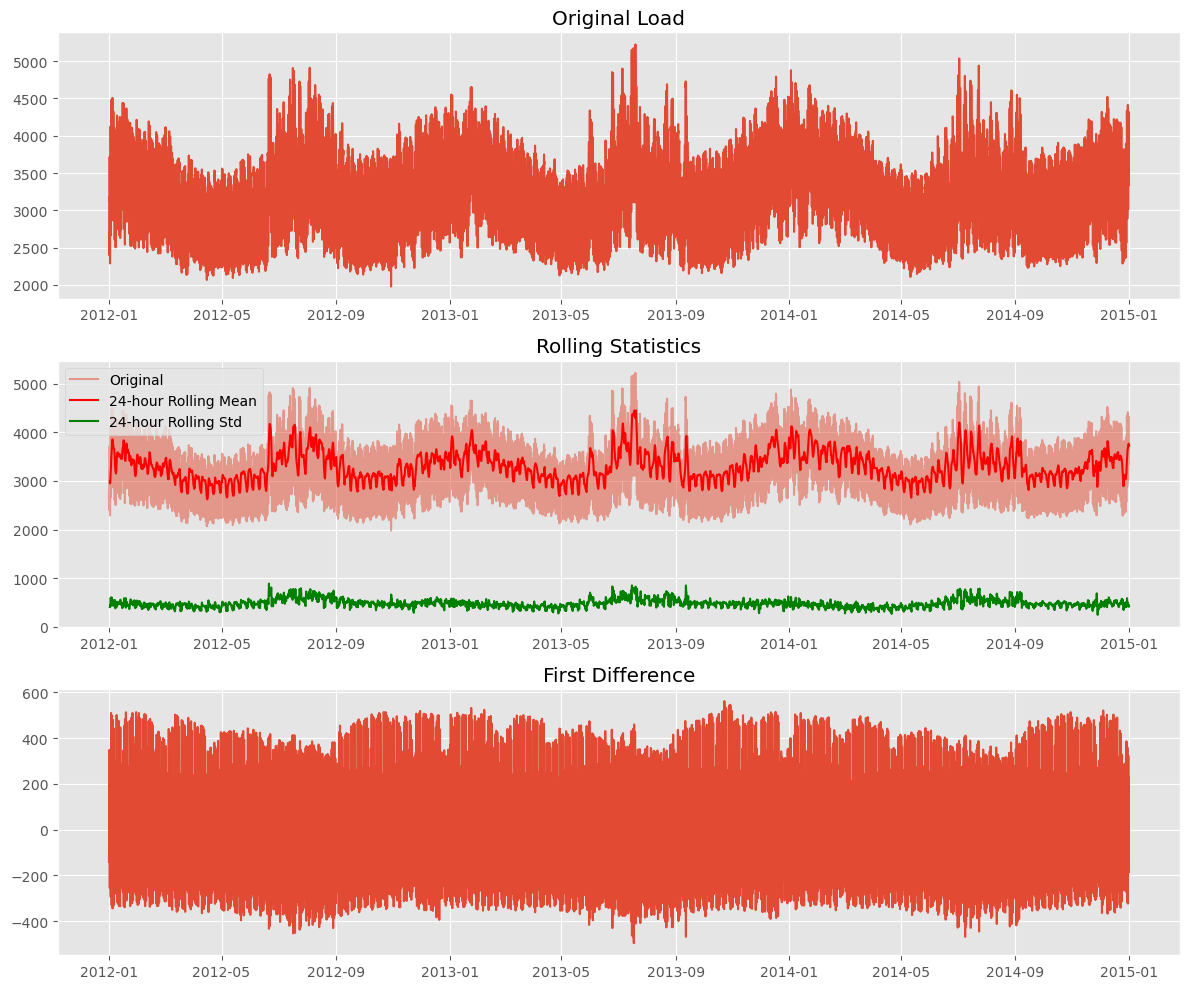


Splitting data into train and test sets...

Training ARIMA model...


C:\Users\Sanika\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Sanika\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


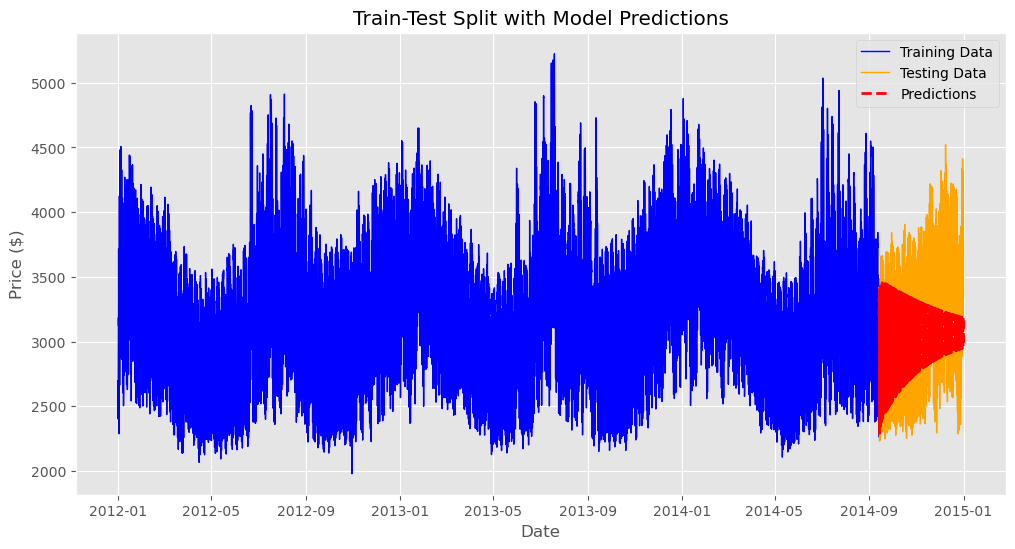


Model RMSE: 402.42 MW

Generating forecast plot...

Error: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'
Please ensure your CSV file is in the correct format:
timestamp, load, temp
Example: 2012-01-01 00:00:00, 2698.0, 32.0


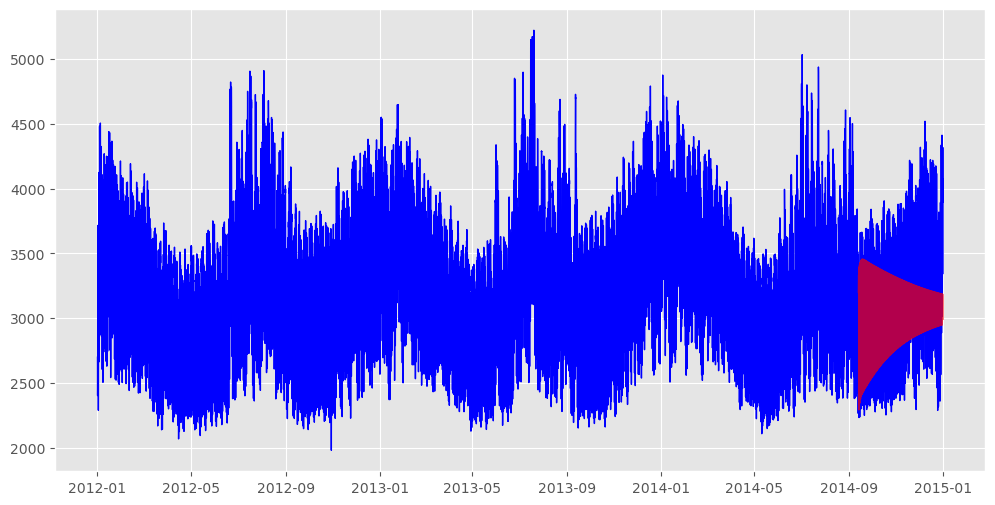

In [19]:
def main():
    # Parameters
    csv = 'energy.csv'
    forecast_hours = 24  # 24 hours forecast
    try:
        print("Reading data from CSV...")
        df = read_data(csv)
        print("\nSuccessfully loaded data!")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        
        print("\nGenerating analysis plots...")
        plot_comprehensive_analysis(df)
        print("\nChecking stationarity...")
        is_stationary = check_stationarity(df['load'])
        print("\nSplitting data into train and test sets...")
        train, test = train_test_split(df)
        print("\nTraining ARIMA model...")
        # Using ARIMA(24,1,24) for hourly data
        model = ARIMA(train['load'], order=(24,1,24))
        results = model.fit()
        
        # Make predictions on the test set
        predictions = results.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        
        # Plot train-test values
        plot_train_test(train, test, predictions)
        # Make forecast
        forecast = results.forecast(steps=forecast_hours)
  
        mse = mean_squared_error(test['load'], predictions)
        rmse = np.sqrt(mse)
        print(f"\nModel RMSE: {rmse:.2f} MW")
        print("\nGenerating forecast plot...")
        plot_forecast_results(df['load'], predictions, forecast)
        print("\nForecast for the next 24 hours:")
        next_day = forecast[:24]
        for date, load in zip(pd.date_range(start=df.index[-1], periods=25, closed='right')[:24], next_day):
            print(f"{date.strftime('%Y-%m-%d %H:00')}: {load:.2f} MW")
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please ensure your CSV file is in the correct format:")
        print("timestamp, load, temp")
        print("Example: 2012-01-01 00:00:00, 2698.0, 32.0")

if __name__ == "__main__":
    main()
